# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import copy
import itertools
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
import seaborn as sns

from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

# Read data and cleaning

In [2]:
data = pd.read_csv("16325569497737558.csv")
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
def check_integers(df):
    validation = 1
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            pass
        else:
            print("Not Valid:", column)
            validation = 0
    if validation == 1:
        print("Everything is okay!")
            

integer_columns = check_integers(data)

Everything is okay!


In [4]:
features_df = data[["age", "sex", "cp", "trtbps", "chol", "fbs", "restecg", "thalachh", "exng", "oldpeak", "slp", "caa", "thall", "output"]]

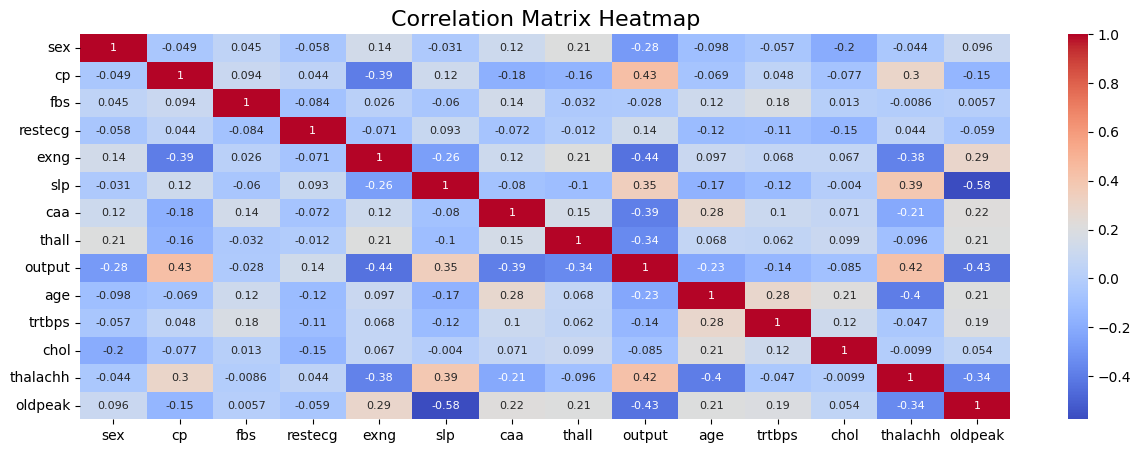

In [8]:
features_to_normalize = ["age", "trtbps", "chol", "thalachh", "oldpeak"]
features_data = features_df[features_to_normalize]
y = features_df[['output']].values


scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_data[features_to_normalize])

normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize)

norm_features_df = pd.concat(
    [features_df.drop(columns=features_to_normalize).reset_index(drop=True),  # Untouched features
     normalized_df.reset_index(drop=True)],  # Normalized selected features
    axis=1
)


correlation_matrix = norm_features_df.corr()
plt.figure(figsize=(15, 5))  # Adjust figure size (width, height)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 8})  # Adjust text size
plt.title("Correlation Matrix Heatmap", fontsize=16)  # Adjust title font size
plt.show()

In [9]:
X = norm_features_df[["cp", "thalachh", "exng", "oldpeak", "slp", "caa", "thall"]].values
y = norm_features_df[["output"]].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.ravel(), y_test.ravel()
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (242, 7) (242,)
Test set: (61, 7) (61,)


# Train models

## KNeighborsClassifier

k:2
	 Train set Accuracy:              0.89256
	 Test set Accuracy:               0.81967
	 Standard Deviation:              0.04923
k:3
	 Train set Accuracy:              0.86777
	 Test set Accuracy:               0.85246
	 Standard Deviation:              0.04541
k:4
	 Train set Accuracy:              0.8719
	 Test set Accuracy:               0.81967
	 Standard Deviation:              0.04923
k:5
	 Train set Accuracy:              0.8595
	 Test set Accuracy:               0.90164
	 Standard Deviation:              0.03813
k:6
	 Train set Accuracy:              0.86777
	 Test set Accuracy:               0.90164
	 Standard Deviation:              0.03813
k:7
	 Train set Accuracy:              0.84711
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081
k:8
	 Train set Accuracy:              0.85537
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081


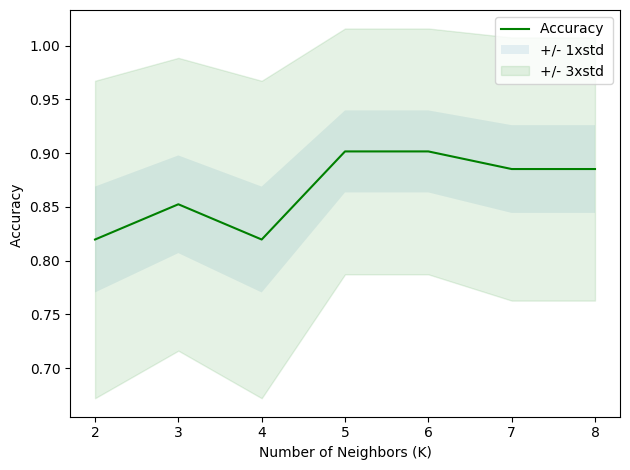

In [11]:
Ks = 9
mean_acc = list()
std_acc = list()

for k in range(2, Ks):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    
    train_accuracy = round(metrics.accuracy_score(y_train, KNN.predict(X_train)), 5)
    test_accuracy = round(metrics.accuracy_score(y_test, KNN.predict(X_test)), 5)
    std = round(np.std(KNN.predict(X_test)==y_test)/np.sqrt(KNN.predict(X_test).shape[0]), 5)

    mean_acc.append([train_accuracy, test_accuracy])
    std_acc.append(std)
    
    print(f"k:{k}")
    print(f"{'\t Train set Accuracy:' :<35}{train_accuracy}")
    print(f"{'\t Test set Accuracy:' :<35}{test_accuracy}")
    print(f"{'\t Standard Deviation:' :<35}{std}")

mean_acc = np.array(mean_acc)
std_acc = np.array(std_acc)

plt.plot(range(2,Ks),mean_acc[:, 1],'g')
plt.fill_between(range(2,Ks), mean_acc[:, 1] - 1 * std_acc, mean_acc[:, 1] + 1 * std_acc, alpha=0.10)
plt.fill_between(range(2,Ks), mean_acc[:, 1] - 3 * std_acc, mean_acc[:, 1] + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [12]:
k = 6
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

## Logistic Regression

In [13]:
mean_acc = list()
std_acc = list()
reg_list = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]

for c in reg_list:
    LR = LogisticRegression(C=c, solver='lbfgs')
    LR.fit(X_train, y_train)
    
    train_accuracy = round(metrics.accuracy_score(y_train, LR.predict(X_train)), 5)
    test_accuracy = round(metrics.accuracy_score(y_test, LR.predict(X_test)), 5)
    std = round(np.std(LR.predict(X_test)==y_test)/np.sqrt(LR.predict(X_test).shape[0]), 5)

    mean_acc.append([train_accuracy, test_accuracy])
    std_acc.append(std)
    
    print(f"{'Regularization strength:' :<44} {c}")
    print(f"{'\t Train set Accuracy:' :<35}{train_accuracy}")
    print(f"{'\t Test set Accuracy:' :<35}{test_accuracy}")
    print(f"{'\t Standard Deviation:' :<35}{std}")

Regularization strength:                     0.01
	 Train set Accuracy:              0.79339
	 Test set Accuracy:               0.86885
	 Standard Deviation:              0.04322
Regularization strength:                     0.05
	 Train set Accuracy:              0.82231
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081
Regularization strength:                     0.1
	 Train set Accuracy:              0.84298
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081
Regularization strength:                     0.3
	 Train set Accuracy:              0.85537
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081
Regularization strength:                     0.5
	 Train set Accuracy:              0.85124
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04081
Regularization strength:                     0.7
	 Train set Accuracy:              0.84711
	 Test set Accur

In [14]:
c = 0.3
LR = LogisticRegression(C=c, solver='lbfgs')
LR.fit(X_train, y_train)

LogisticRegression(C=0.3)

## Decision Trees

In [15]:
max_d = 9
for d in range(3,max_d):
    DTC = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DTC.fit(X_train, y_train)
    train_accuracy = round(metrics.accuracy_score(y_train, DTC.predict(X_train)), 5)
    test_accuracy = round(metrics.accuracy_score(y_test, DTC.predict(X_test)), 5)
    std = round(np.std(DTC.predict(X_test)==y_test)/np.sqrt(DTC.predict(X_test).shape[0]), 5)

    mean_acc.append([train_accuracy, test_accuracy])
    std_acc.append(std)
    
    print(f"{'Maximum depth:' :<44} {d}")
    print(f"{'\t Train set Accuracy:' :<35}{train_accuracy}")
    print(f"{'\t Test set Accuracy:' :<35}{test_accuracy}")
    print(f"{'\t Standard Deviation:' :<35}{std}")

Maximum depth:                               3
	 Train set Accuracy:              0.84711
	 Test set Accuracy:               0.81967
	 Standard Deviation:              0.04923
Maximum depth:                               4
	 Train set Accuracy:              0.8719
	 Test set Accuracy:               0.85246
	 Standard Deviation:              0.04541
Maximum depth:                               5
	 Train set Accuracy:              0.90496
	 Test set Accuracy:               0.83607
	 Standard Deviation:              0.0474
Maximum depth:                               6
	 Train set Accuracy:              0.93802
	 Test set Accuracy:               0.86885
	 Standard Deviation:              0.04322
Maximum depth:                               7
	 Train set Accuracy:              0.97521
	 Test set Accuracy:               0.83607
	 Standard Deviation:              0.0474
Maximum depth:                               8
	 Train set Accuracy:              0.9876
	 Test set Accuracy:              

In [16]:
d = 6
DTC = DecisionTreeClassifier(criterion="entropy", max_depth=d)
DTC.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

## SVM (Support Vector Machines)

In [17]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    SVM = SVC(kernel=k)
    SVM.fit(X_train, y_train) 
    train_accuracy = round(metrics.accuracy_score(y_train, SVM.predict(X_train)), 5)
    test_accuracy = round(metrics.accuracy_score(y_test, SVM.predict(X_test)), 5)
    std = round(np.std(DTC.predict(X_test)==y_test)/np.sqrt(SVM.predict(X_test).shape[0]), 5)

    mean_acc.append([train_accuracy, test_accuracy])
    std_acc.append(std)
    
    print(f"{'Regularization strength:' :<44} {k}")
    print(f"{'\t Train set Accuracy:' :<35}{train_accuracy}")
    print(f"{'\t Test set Accuracy:' :<35}{test_accuracy}")
    print(f"{'\t Standard Deviation:' :<35}{std}")

Regularization strength:                     linear
	 Train set Accuracy:              0.85124
	 Test set Accuracy:               0.88525
	 Standard Deviation:              0.04322
Regularization strength:                     poly
	 Train set Accuracy:              0.85537
	 Test set Accuracy:               0.85246
	 Standard Deviation:              0.04322
Regularization strength:                     rbf
	 Train set Accuracy:              0.85537
	 Test set Accuracy:               0.86885
	 Standard Deviation:              0.04322
Regularization strength:                     sigmoid
	 Train set Accuracy:              0.76446
	 Test set Accuracy:               0.85246
	 Standard Deviation:              0.04322


In [18]:
SVM = SVC(kernel='linear')
SVM.fit(X_train, y_train) 

SVC(kernel='linear')

## Evaluation

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNeighborsClassifier

classification_report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

jaccard score: 0.8286
Confusion matrix, without normalization
[[26  3]
 [ 3 29]]


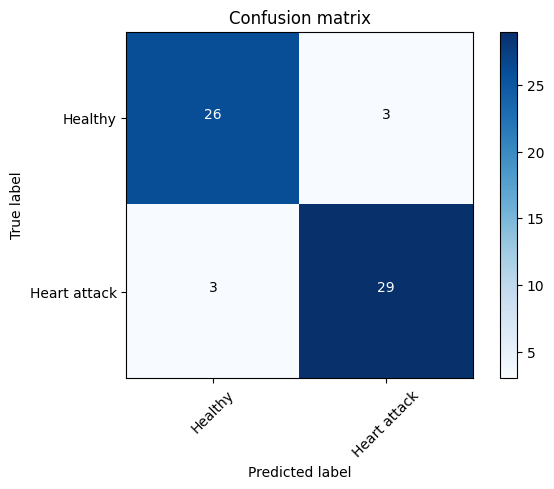

In [20]:
test_pred = KNN.predict(X_test)

print(f"classification_report:\n {classification_report(y_test, test_pred)}")
print(f"jaccard score: {round(jaccard_score(y_test, test_pred, pos_label=1), 4)}")

cnf_matrix = confusion_matrix(y_test, test_pred, labels=[0,1])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy','Heart attack'],normalize= False,  title='Confusion matrix')
plt.show()

### Logistic Regression

classification_report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

jaccard score: 0.8056
Confusion matrix, without normalization
[[25  4]
 [ 3 29]]


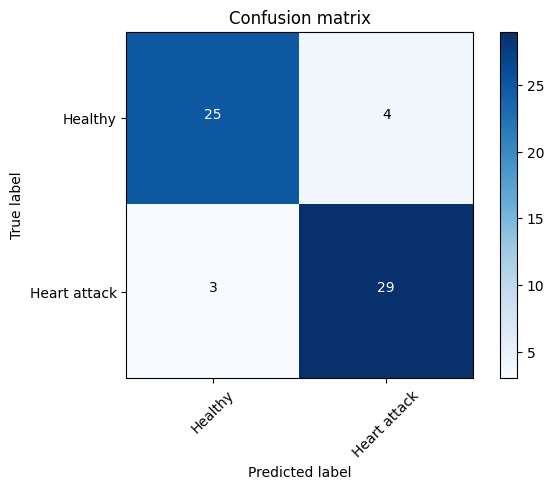

In [21]:
test_pred = LR.predict(X_test)

print(f"classification_report:\n {classification_report(y_test, test_pred)}")
print(f"jaccard score: {round(jaccard_score(y_test, test_pred, pos_label=1), 4)}")

cnf_matrix = confusion_matrix(y_test, test_pred, labels=[0,1])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy','Heart attack'],normalize= False,  title='Confusion matrix')
plt.show()

### Decision Trees

classification_report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

jaccard score: 0.7778
Confusion matrix, without normalization
[[25  4]
 [ 4 28]]


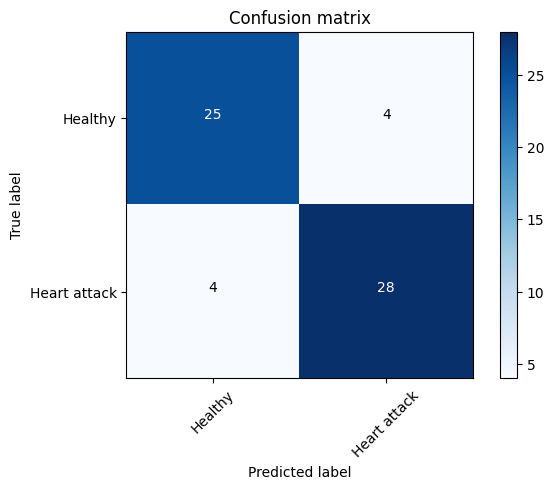

In [22]:
test_pred = DTC.predict(X_test)

print(f"classification_report:\n {classification_report(y_test, test_pred)}")
print(f"jaccard score: {round(jaccard_score(y_test, test_pred, pos_label=1), 4)}")

cnf_matrix = confusion_matrix(y_test, test_pred, labels=[0,1])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy','Heart attack'],normalize= False,  title='Confusion matrix')
plt.show()

### Support vector machine

classification_report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

jaccard score: 0.8056
Confusion matrix, without normalization
[[25  4]
 [ 3 29]]


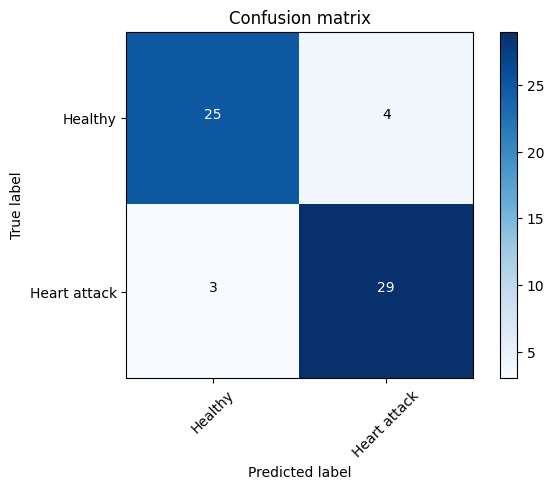

In [23]:
test_pred = SVM.predict(X_test)

print(f"classification_report:\n {classification_report(y_test, test_pred)}")
print(f"jaccard score: {round(jaccard_score(y_test, test_pred, pos_label=1), 4)}")

cnf_matrix = confusion_matrix(y_test, test_pred, labels=[0,1])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy','Heart attack'],normalize= False,  title='Confusion matrix')
plt.show()